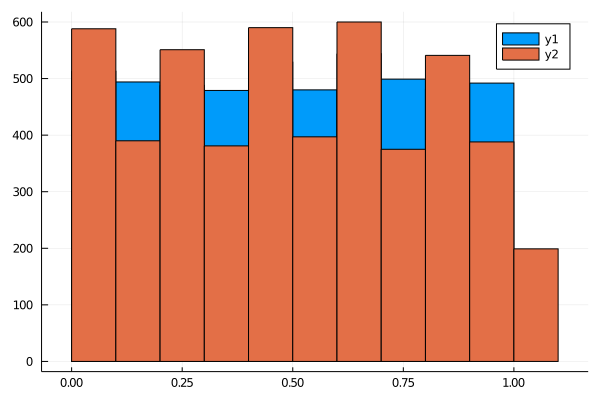

In [75]:
using Flux
using Plots
using Random
using Distributions

function process(input)
    Float32.(transpose(input))
end

nbatch = 5000

N = 25
mu = rand(nbatch) |> process #Unif[0,1]
nu = floor.(rand(nbatch) * (N+1)) / N |> process #Uniform{0,1/N,...,1}

# d1 = Normal(5,1)
# d2 = Normal(0,10)
# mu = rand(d1, nbatch) |> process
# nu = rand(d2, nbatch) |> process

data = collect(zip(mu, nu))
datanew = [([x],[y]) for (x,y) in data]

p = histogram(transpose(mu))
histogram!(p, transpose(nu))

In [76]:
f = Chain(Dense(1, 100, relu), Dense(100, 50, relu), Dense(50, 1, sigmoid)); #No clue what to make this neural network

In [77]:
using Flux:train!
using Statistics

function prune(x, threshold)
    if x < -threshold
        return -threshold
    elseif x > threshold
        return threshold
    else
        return x
    end
end

function clip_weights(model, threshold)
    for i in 1:length(Flux.params(model))
        if i % 2 == 1
            Flux.params(model)[i] .= prune.(Flux.params(model)[i], threshold)
        end
    end
end

function loss(model, mu, nu)
    -(mean(model(mu)) - mean(model(nu)))
end

function pred_WassersteinDist(f, mu, nu)
    -loss(f, mu, nu)
end

opt = Flux.setup(RMSProp(0.00005), f)
#opt = Flux.setup(Adam(), ClipValue(1e-2), f) 
#opt = Optimiser(ClipValue(1e-2), Adam(1e-3))

epochs = 400
c = 0.01
d = [pred_WassersteinDist(f, mu, nu)]

for i in 1:epochs
    Flux.train!(loss, f, datanew, opt)
    clip_weights(f, c)
    #println("iteration $i: ", Flux.params(f))
    push!(d, pred_WassersteinDist(f, mu, nu))
end

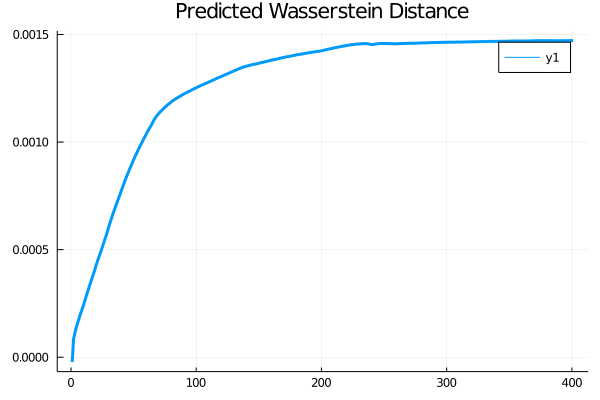

In [78]:
plot(d, title = "Predicted Wasserstein Distance", linewidth=3)

In [79]:
println("Wasserstein Distance: ", 1/N)

println("Predicted Distance: ", pred_WassersteinDist(f, mu, nu))

In [80]:
function find_max_weight(model)
    max_weight = -1e6
    for i in 1:length(Flux.params(model))
        if i % 2 == 1
            max_weight = max(max_weight, maximum(Flux.params(model)[i]))
        end
    end
    max_weight
end

function find_max_abs_weight(model)
    max_weight = -1e6
    for i in 1:length(Flux.params(model))
        if i % 2 == 1
            max_weight = max(max_weight, maximum(abs.(Flux.params(model)[i])))
        end
    end
    max_weight
end

println(Flux.params(f))

println(find_max_weight(f))
println(find_max_abs_weight(f))